[<- back to main page](implementation.ipynb)

# Example 3: Curvilinear scalings

Similar to [before](circular.ipynb) we consider a two-dimensional example, namely $\Omega:=\mathbb R^2\setminus B_{R}(\mathbf x_0)$, some center $\mathbf x_0\in B_1(0)$ and radius $R$.
This time we allow an arbitrary boundary $\Gamma$ which is convex such that $B_R(\mathbf x_0)$ is contained in the interior of $\Gamma$.

We choose curvilinear coordinates given by

$$\mathbf x(\xi,\hat x):=\hat x+\xi\mathbf n(\hat x)$$
(cf. [Section 7.1.3](dissertation_wess.pdf#subsection.7.1.3)).

Again, we create the according mesh and set some parameters.

In [1]:
from ngsolve import *
from netgen.geom2d import *
from nonlin_arnoldis import *
from ngsolve.webgui import Draw
from numpy import array,sqrt,loadtxt
from matplotlib.pyplot import plot,show,xlim,ylim,legend

N = 25         #infinite elements
maxh = 0.1     #mesh-size
sigma = 0.1+0.3j   #complex scaling paramter
order = 5      #fem order
shift = 4-0.5j      #shift for Arnoldi algorithm
center = (0.2,0)    #center of inner circle
R = 0.5            #radius of inner circle

#create geometry
def MakeEggGeometry(Rx,Ryt,Ryb):
    geo = SplineGeometry()
    pts = [(x,y) for y in [-Ryb,0,Ryt] for x in [-Rx,0,Rx]]
    for pt in pts:
        geo.AppendPoint(*pt)

    inds = [(1,2,5),(5,8,7),(7,6,3),(3,0,1)]
    for i in inds:
        geo.Append(['spline3',*i],bc='outer',leftdomain=1,rightdomain=0)
    geo.AddCircle(center,R,leftdomain=0,rightdomain=1,bc='inner')
    return geo

geo = MakeEggGeometry(0.8,0.7,1.2)


#create mesh
mesh = Mesh(geo.GenerateMesh(maxh=maxh))
mesh.Curve(2*order)
Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': N…

The weak formulation after a re-scaling of the solution and testfunction in the exterior is given by [(7.12)](dissertation_wess.pdf#equation.7.2.12).

Contrary to [polar coordinates](circular.ipynb) and [star-shaped coordinates](star_shaped.ipynb)this time we also need the normal vecter $\mathbf n(\hat x)$ and the curvature $\kappa(\hat x)$ and the tangential vector $\mathbf t(\hat x)$.

In [2]:
n = specialcf.normal(2)
kappa = Trace(grad(n))
t = CoefficientFunction((n[1],-n[0]))

For this first simple example we again choose a frequency independent scaling
$$\sigma(\omega):=\sigma_0\in\mathbb C,$$
(cf. [(7.14a)](dissertation_wess.pdf#equation.7.3.14a)).

We start by creating the large finite element space for implementing our [tensor-product method](tp_disc.ipynb). Contrary to before we need an additional surface space, since [(7.12)](dissertation_wess.pdf#equation.7.2.12) contains an additional variable to be able to seperate the bilinear forms into a radial and a surface part (cf. [Remark 7.1](dissertation_wess.pdf#thm.7.1) and [Section 7.2](dissertation_wess.pdf#section.7.2)).

In [3]:
Gamma = mesh.Boundaries('outer')

fes_int = H1(mesh,order=order,complex=True)
fes_surf = H1(mesh,order=order,complex=True,definedon=Gamma)
fes_surf_l2 = SurfaceL2(mesh,order=order-1,complex=True,definedon=Gamma)

fes_p = ProductSpace(fes_int,*( N*[fes_surf]) )
fes_u = ProductSpace(*( (N+1)*[fes_surf_l2]))

fes = ProductSpace(fes_p,fes_u)

We import the necessary [infinte element matrices](infinite_elements.ipynb) and prepare the radial matrices:

In [4]:
from infinite_elements import *

ie_mass,ie_laplace,_,ie_mass_x,_,ie_laplace_x,_,_ = ie_matrices(N)

Now we can assemble our bilinear forms.

In [5]:
ds_g = ds(definedon=Gamma)
(p,u),(q,v) = fes.TnT()
p_int,q_int = p[0],q[0]
S = BilinearForm(
    grad(p_int)*grad(q_int)*dx
    
    +sum(1/sigma*ie_laplace[i,j]*p[j]*q[i]*ds_g
       for i in range(N+1) for j in range(N+1) if abs(ie_laplace[i,j])>0)
    
    +sum(ie_laplace_x[i,j]*kappa*p[i]*q[j]*ds_g
       for i in range(N+1) for j in range(N+1) if abs(ie_laplace_x[i,j])>0)
    
    +sum(sigma*ie_mass[i,j]*(u[i].Trace()*(t*q[j].Trace().Deriv()) + (t*p[i].Trace().Deriv())*v[j].Trace())*ds_g
       for i in range(N+1) for j in range(N+1) if abs(ie_mass[i,j])>0)
    
    -sum(sigma*ie_mass[i,j]*u[i].Trace()*v[j].Trace()*ds_g
       for i in range(N+1) for j in range(N+1) if abs(ie_mass[i,j])>0)
    
    -sum(sigma**2*ie_mass_x[i,j]*kappa*u[i].Trace()*v[j].Trace()*ds_g
       for i in range(N+1) for j in range(N+1) if abs(ie_mass_x[i,j])>0)
    
    ,symmetric=True).Assemble()

M = BilinearForm(
    -p_int*q_int*dx
    -sum(sigma*ie_mass[i,j]*p[j]*q[i]*ds_g
       for i in range(N+1) for j in range(N+1) if abs(ie_mass[i,j])>0)
    
    -sum(sigma**2*ie_mass_x[i,j]*kappa*p[j]*q[i]*ds_g
       for i in range(N+1) for j in range(N+1) if abs(ie_mass_x[i,j])>0)
    
    ,symmetric=True).Assemble()


Finally, we solve the resulting eigenvalue problem.

initialized PolyArnoldi for EVP of order 1 with 22632 dofs
called CalcInverse
inverting P(shift)
inverted in 2.2571478429999843 seconds
building Krylow space of dimension 200
starting iteration
Krylowspace built in 10.676209687000664 seconds
called SolveHessenberg
solved Hessenberg EVP in 0.477220312001009 seconds
calculating 100 big vectors


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

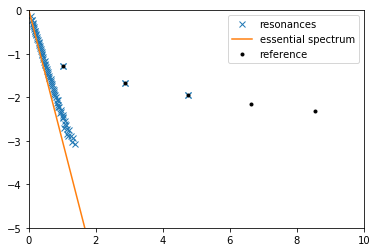

In [6]:
gf = GridFunction(fes,multidim=100)

#lam = sqrt(array(ArnoldiSolver(S.mat,M.mat,freedofs=fes.FreeDofs(),vecs=gf.vecs,shift=shift**2)))
lam = sqrt(array(PolyArnoldiSolver([S.mat,M.mat],shift**2,200,nevals=80,vecs=gf.vecs,inversetype='sparsecholesky',freedofs=fes.FreeDofs())))

plot(lam.real,lam.imag,'x',label='resonances')
plot([0,5*(1/sigma).real],[0,5*(1/sigma).imag],label='essential spectrum')

#load reference resonances from file
loaded=loadtxt('dhankel_1_zeros.out')
ref=(loaded[:,0]+1j*loaded[:,1])/R

plot(ref.real,ref.imag,'.k',label='reference')

xlim((0,10))
ylim((-5,0))
legend()
Draw(gf.components[0].components[0])

[<- back to main page](implementation.ipynb)